##Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dense
import scipy.io
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras import optimizers
from sklearn.metrics import r2_score
import seaborn as sns

##Feed Forward Neural Network

In [2]:
dataset = scipy.io.loadmat('drive/MyDrive/MLThesis/data/qm7.mat')

X = dataset['X'].reshape((7165, 529, 1)) 
Y = np.transpose(dataset["T"]).reshape((7165,))

container = []
for i in X:
  container.append(i.max())
  

X_max = max(container)
Y_max = np.abs(dataset["T"].min())


X_scaled = X / X_max
Y_scaled = Y / Y_max


# Leave data that will be "unseen" in X_test and Y_test variables
X_trainvalidate, X_test, Y_trainvalidate, Y_test = train_test_split(X_scaled, Y_scaled,  
                                                    test_size=.15, 
                                                    random_state=666)

# Data for the algo input
X_train, X_validation, Y_train, Y_validation = train_test_split(X_trainvalidate, Y_trainvalidate,  test_size=.18, random_state=666)


model = Sequential()
kernel_initializer='he_normal'

# 64 -> 128 -> 529 -> Flatten -> 1
model.add(Dense(529, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(16, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(8, activation='relu', kernel_initializer=kernel_initializer))
model.add(Flatten())
model.add(Dense(1, activation='linear'))


model.compile(loss='mae',
              optimizer=optimizers.Adam(.001),
              metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])



start = time.time()


reduce_eta = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)

n_epochs = 10

history = model.fit(X_train, Y_train,
                      batch_size=4,
                      epochs=n_epochs, 
                      callbacks=[reduce_eta],
                      verbose=1,
                      validation_data=(X_validation, Y_validation))

model.summary()

end = time.time()

print(f"Training time: {end-start}")
print(f"Number of epochs: {n_epochs}")

Epoch 1/10
1249/1249 [==============================] - 40s 15ms/step - loss: 0.0689 - mae: 0.0689 - root_mean_squared_error: 0.1746 - val_loss: 0.0153 - val_mae: 0.0153 - val_root_mean_squared_error: 0.0627
Epoch 2/10
1249/1249 [==============================] - 18s 14ms/step - loss: 0.0226 - mae: 0.0226 - root_mean_squared_error: 0.0564 - val_loss: 0.0195 - val_mae: 0.0195 - val_root_mean_squared_error: 0.0473

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/10
1249/1249 [==============================] - 18s 14ms/step - loss: 0.0133 - mae: 0.0133 - root_mean_squared_error: 0.0447 - val_loss: 0.0136 - val_mae: 0.0136 - val_root_mean_squared_error: 0.0398
Epoch 4/10
1249/1249 [==============================] - 18s 15ms/step - loss: 0.0127 - mae: 0.0127 - root_mean_squared_error: 0.0383 - val_loss: 0.0113 - val_mae: 0.0113 - val_root_mean_squared_error: 0.0354
Epoch 5/10
1249/1249 [==============================] - 18s 14ms/step - loss: 0.0125 -

## Validation

In [3]:
approximated_energy = model.predict(X_test)

print(f"Test dataset error (MAE): {Y_max*mean_absolute_error(Y_test, approximated_energy)}")
print(f"Test dataset error (RMSE): {Y_max*mean_squared_error(Y_test, approximated_energy, squared=False)}")

Test dataset error (MAE): 24.01999855041504
Test dataset error (RMSE): 32.46558380126953


In [4]:
#plt.figure(figsize=(8,8))

loss = np.array(history.history["loss"]) * Y_max
mae = np.array(history.history["mae"]) * Y_max
#rmse = np.array(history.history["mae"]) * y_max
val_loss = np.array(history.history["val_loss"]) * Y_max
val_mae = np.array(history.history["val_mae"]) * Y_max
#val_rmse = np.array(history.history["mae"]) * y_max

epochs = [x for x in range(1, n_epochs + 1)]


#print(loss)
#print(val_loss)

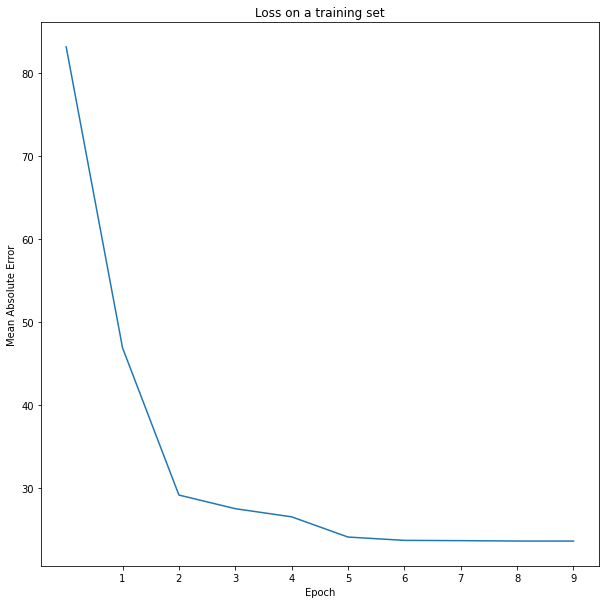

In [5]:
plt.figure(figsize=(10,10))
plt.title("Loss on a training set")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.xticks(epochs)
plt.plot(loss)

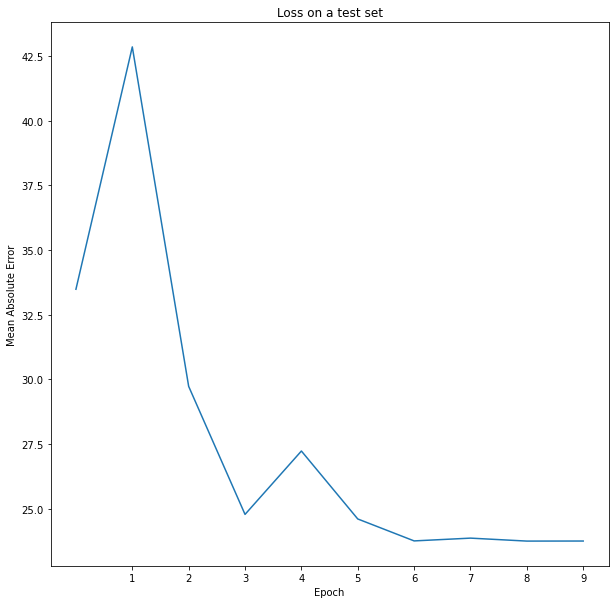

In [6]:
plt.figure(figsize=(10,10))
plt.title("Loss on a test set")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.xticks(epochs)
plt.plot(val_loss)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


R2 - regression score function - is: 0.9770211115144053


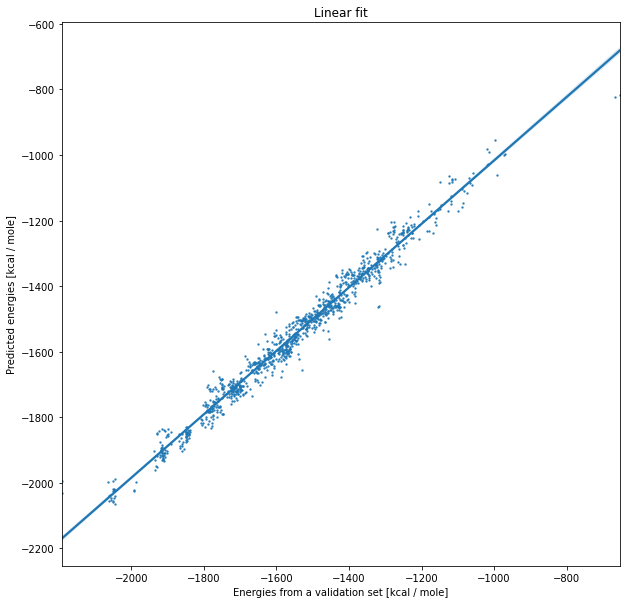

In [7]:
plt.figure(figsize=(10,10))
plt.title("Linear fit")
plt.xlabel("Energies from a validation set [kcal / mole]")
plt.ylabel("Predicted energies [kcal / mole]")

sns.regplot(Y_test * Y_max, approximated_energy * Y_max, marker="o", scatter_kws={'s':2})
print(f"R2 - regression score function - is: {r2_score(Y_max * Y_test, Y_max * approximated_energy)}")

(-1.0, -0.2)

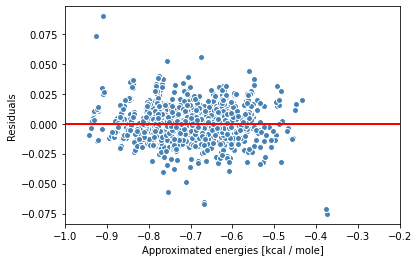

In [8]:
plt.scatter(approximated_energy, approximated_energy - Y_test.reshape(1075, 1), c='steelblue', marker='o', edgecolor='white', label='Test data')
plt.xlabel("Approximated energies [kcal / mole]")
plt.ylabel("Residuals")
plt.hlines(y=0, xmin=-1.0, xmax=-0.20, color='red', lw=2)
plt.xlim([-1.0, -0.20])